Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

Structure inspired from https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

# Imports & Setting up directories

In [45]:
import sys; sys.path.insert(0, '..') 
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install torchdiffeq

    %cd /content/drive/MyDrive/1_SP_Ham_func/src/furuta
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/data.py 
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/dynamics.py 
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/models.py 
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/train.py 
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/plots.py 
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/trajectories.py 
    !wget --no-cache --backups=1 https://raw.githubusercontent.com/unesmu/SP_Learn_Ham_func/main/src/furuta/utils.py 

    %cd ..
    %cd ..
    
    from src.furuta.data import *
    from src.furuta.dynamics import *
    from src.furuta.models import *
    from src.furuta.train import *
    from src.furuta.plots import *
    from src.furuta.trajectories import *
    from src.furuta.utils import *
    # !pip install torchdiffeq
    #   # Clone the entire repo to access the files.
    #   !git clone -l -s https://github.com/....... repo
    # Mount your google drive 
else:
    from src.furuta.data import *
    from src.furuta.dynamics import *
    from src.furuta.models import *
    from src.furuta.train import *
    from src.furuta.plots import *
    from src.furuta.trajectories import *
    from src.furuta.utils import *
    PATH = '../'

# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

In [ ]:
from src.furuta.data import *
from src.furuta.dynamics import *
from src.furuta.models import *
from src.furuta.train import *
from src.furuta.plots import *
from src.furuta.trajectories import *
from src.furuta.utils import *

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate, load and save the dataset

In [56]:
device = set_device()
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = 'fake')

cpu


In [ ]:
def u_func(t, utype='tanh'):  
  ''' time dependent input '''
  if utype == 'tanh':
      u = (-torch.tanh((t-0.75)*4)+1)/100
  elif utype == 'CHIRP':
      u = chirp_fun(t,T=1.5,f0=1,f1=10)
  elif utype == 'multisine':
      u = multi_sine(t)
  elif utype == 'step':
      u = step_fun(t, t1=0.05)
  u.requires_grad=False
  return u

In [97]:
utype='CHIRP'
gtype='simple'
init_method = 'random_closetopi'

In [82]:
train_loader, test_loader, stds = load_data_device(device, utype=utype, gtype=gtype, init_method=init_method, 
                                                   u_func=u_func, g_func=g_func, time_steps=5, 
                                                   shuffle = False, 
                                                   num_trajectories=125, 
                                                   coord_type='hamiltonian', 
                                                   proportion=0.8, batch_size=100, 
                                                   Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                                   g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)

In [85]:
suffix = 'Ts_{:.3f}_Jr_{:.2f}_Lr_{:.2f}_Mp_{:.2f}__Lp_{:.2f}'.format(Ts, Jr, Lr, Mp, Lp)
suffix = suffix + '_'+ utype+ '_'
print(suffix)

Ts_0.005_Jr_0.00_Lr_0.50_Mp_5.00__Lp_0.10_CHIRP_


In [59]:
# import os
# os.getcwd()
# os.makedirs('../data/experiment_1/', exist_ok=True)
# filename = '../data/experiment_1/1/simulation_{}.{}'
# filename.format(1,2)

In [60]:
train_loader_path = PATH + 'data/datasets/train_loader_' + suffix + '.pt'
test_loader_path = PATH + 'data/datasets/test_loader_' + suffix + '.pt'

In [61]:
torch.save(train_loader, train_loader_path)
if test_loader is not None:
    torch.save(test_loader, test_loader_path)

In [ ]:
train_loader = torch.load(train_loader_path)
test_loader = torch.load(test_loader_path)

# Training

In [62]:
model = load_model_nes_hdnn(device,utype=utype, u_func=u_func, hidden_dim=90, nb_hidden_layers=4) # load_model(hidden_dim=90, nb_hidden_layers=4)
num_params = count_parameters(model)
print(num_params) 

38043


In [63]:
weights = [1.0, 1.0, 10.0, 10.0] # [1.0, 5.0, 10.0, 15.0]

weights_title = ' | weights = ' + str(weights)
print('weights',weights)
horizon_list = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
                200,210,220,230,240,250,260,270,280,290,300]
                #list(range(20,301,10))

switch_steps = [300,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,
                100,100,100,100,50,50,50,50,50,50,50,50,100]
#[100]*len(horizon_list) # [150,150,150,150,150,150,150,150,150,150,150,150,150,150]

print(len(horizon_list))
print(len(switch_steps))
epoch_number = sum(switch_steps)
print(epoch_number)

weights [1.0, 5.0, 10.0, 15.0]
29
29
2500


In [86]:
save_prefix = '{:d}e_w_{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_ts_{:1.3f}__'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
save_prefix = save_prefix+ '_'+ utype+ '_'
print(save_prefix)

2500e_w_001.0_005.0_010.0_015.0_p38k_ts_0.005___CHIRP_


horizon length : 20


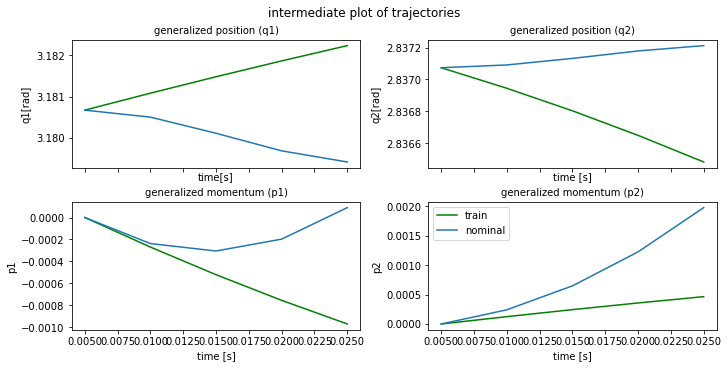

plot time : 0.8215277194976807
epoch    0 | train time 0.96 | train loss 8.752167e-04 | test loss 7.930805e-04 | test time 0.04  
horizon length : 20
epoch    1 | train time 0.12 | train loss 8.004296e-04 
epoch    2 | train time 0.11 | train loss 8.132019e-04 


In [65]:
stats = train(model, 
              Ts, 
              train_loader, 
              test_loader, 
              w=torch.tensor(weights, device=device),
              epoch_number = epoch_number,
              horizon = False, 
              horizon_type = 'auto', 
              horizon_list = horizon_list, 
              switch_steps = switch_steps, 
              epochs = 3, 
              loss_type = 'L2weighted2') # L2normalizedfixed3 0.5

In [ ]:
stats = train_alternating(model, 
              Ts, 
              train_loader, 
              test_loader, 
              w=torch.tensor(weights, device=device), 
              epoch_number=epoch_number,
              horizon = False, 
              horizon_type = 'auto', 
              horizon_list = horizon_list, 
              switch_steps = switch_steps, 
              epochs = epoch_number, 
              loss_type = 'L2weighted2') # L2normalizedfixed3 0.5

# Saving model and stats

In [66]:
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'

In [67]:
# save the stats
save_stats(PATH, stats, stats_path)

In [68]:
# loads the stats 
stats = read_dict(PATH, stats_path)

In [69]:
model_name = 'models/'+save_prefix+'model_test'

In [70]:
# save model to disk
model_name = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_name)

In [87]:
# load the model from disk
model = load_model_nes_hdnn(device,utype=utype, u_func=u_func, hidden_dim=90, nb_hidden_layers=4) # load_model(hidden_dim=90, nb_hidden_layers=4)
#load_model(device, hidden_dim=90, nb_hidden_layers=4)
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

Nes_HDNN(
  (H_net): MLP(
    (fc1): Linear(in_features=4, out_features=90, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (1): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (2): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (3): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
    )
    (fc2): Linear(in_features=90, out_features=1, bias=True)
  )
  (G_net): MLP(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [72]:
print(model.C2_dissip)
print(model.C1_dissip)

Parameter containing:
tensor([0.1414], requires_grad=True)
Parameter containing:
tensor([0.1414], requires_grad=True)


# Plots

In [73]:
horizon_steps = []
horizon_steps.append(0)
for i, number in enumerate(switch_steps) :
  horizon_steps.append(horizon_steps[i] +number) 
horizon_steps = horizon_steps[1:-1]
# horizon_steps

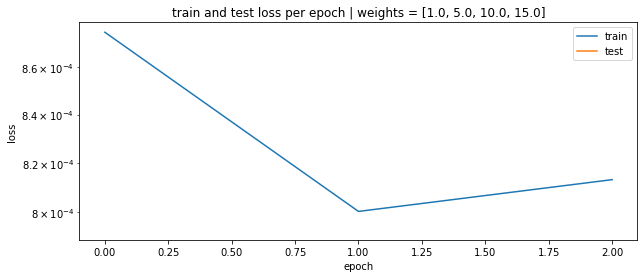

IndexError: index 100 is out of bounds for axis 0 with size 3

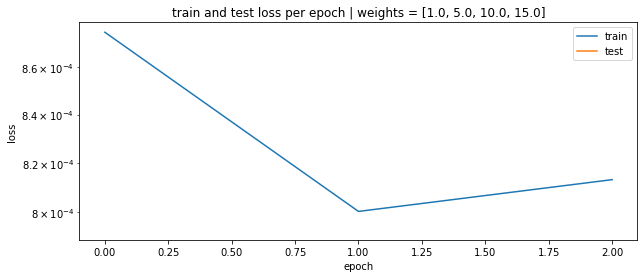

In [76]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_1.png', 
                     title='train and test loss per epoch'+ weights_title, horizons= False )

train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_2.png', 
                     title='train and test loss per epoch'+ weights_title, horizons= horizon_list[:-1], horizon_steps = horizon_steps )

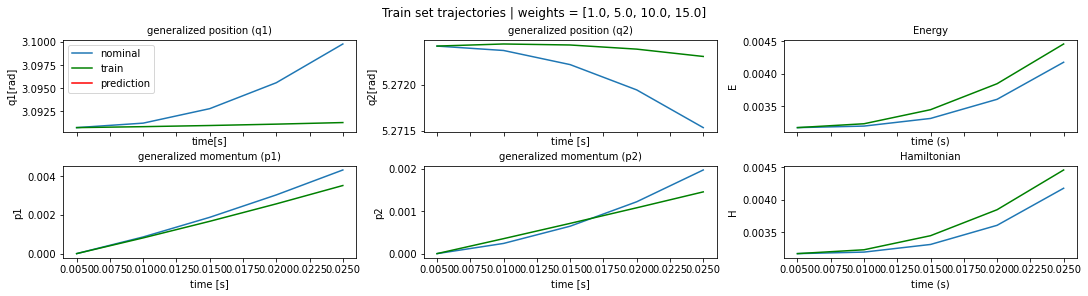

In [89]:
n=10
plot_furuta_hat_nom(model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Train set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

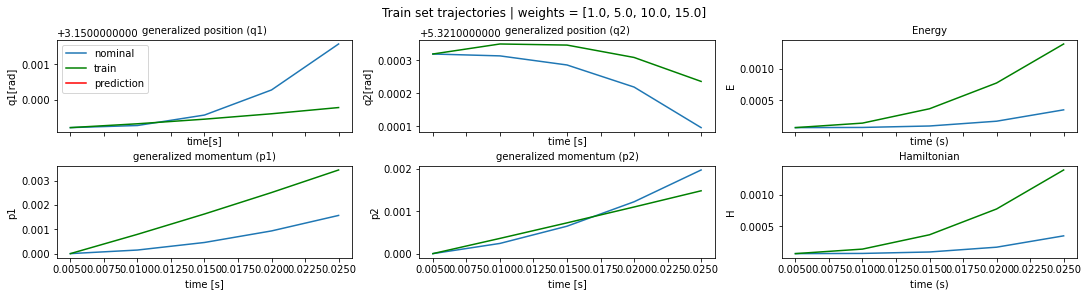

In [92]:
n=20
plot_furuta_hat_nom(model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Train set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

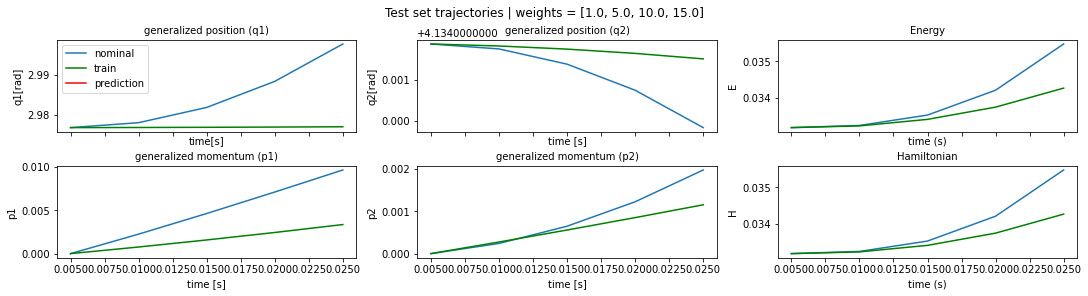

In [93]:
n = 10 

plot_furuta_hat_nom(model, u_func, g_func, utype, gtype, data_loader_t=test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
n = 7
plot_furuta_hat_nom(model, u_func, g_func, utype, gtype, data_loader_t=test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

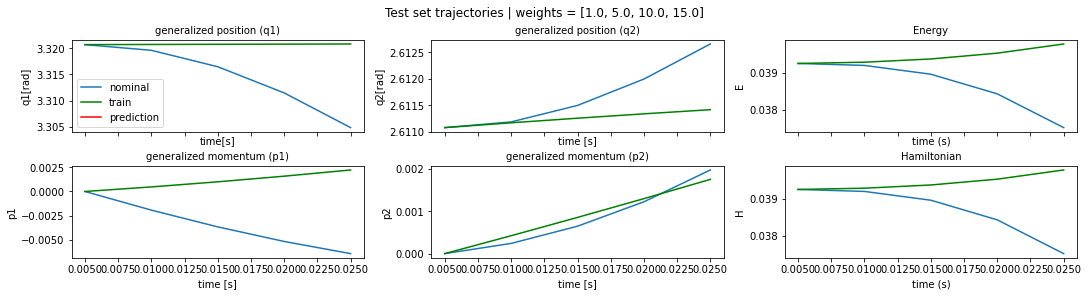

In [94]:
n = 12
plot_furuta_hat_nom(model, u_func, g_func, utype, gtype, data_loader_t=test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=None)#PATH+'data/img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [99]:
test_loader_3, _ , _ = load_data_device(device, utype, gtype, init_method=init_method,u_func=u_func, g_func=g_func, time_steps=100, num_trajectories=2,  coord_type='hamiltonian', proportion=0.0, batch_size=1,
                                        noise_std=noise_std, Ts=Ts,C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp)


In [103]:
test_loader_path_3 = PATH + 'data/datasets/test_loader_longer_3' + suffix + '.pt'

In [104]:
torch.save(test_loader_3, test_loader_path_3)

In [105]:
test_loader_3 = torch.load(test_loader_path_3)

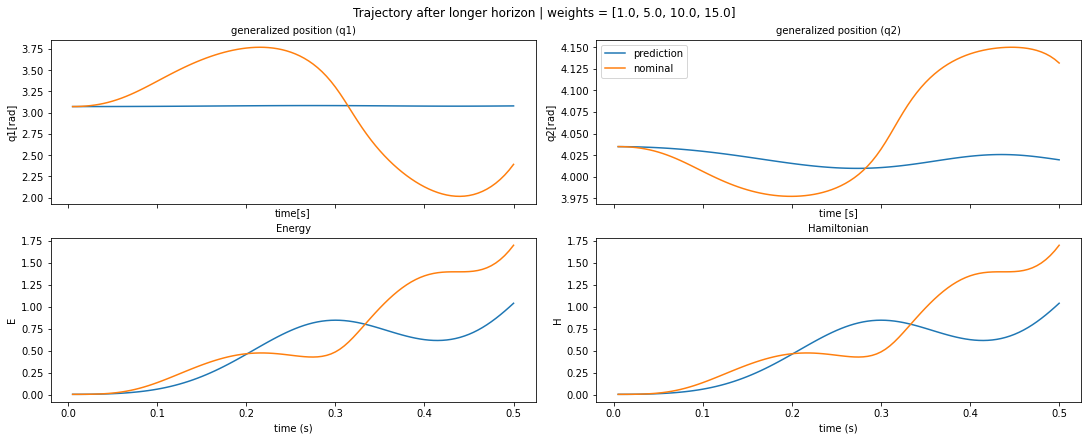

In [109]:
plot_longer_horizon_furuta(model, u_func, g_func, utype, gtype, test_loader=test_loader_3,t1=0,t2=2000, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=PATH+'img/'+save_prefix+'TRAJ_longer_horizon1.png')

In [ ]:
plot_longer_horizon_furuta(model, u_func, g_func, utype, gtype, test_loader=test_loader_3,t1=2000,t2=10000, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=PATH+'img/'+save_prefix+'TRAJ_longer_horizon2.png')

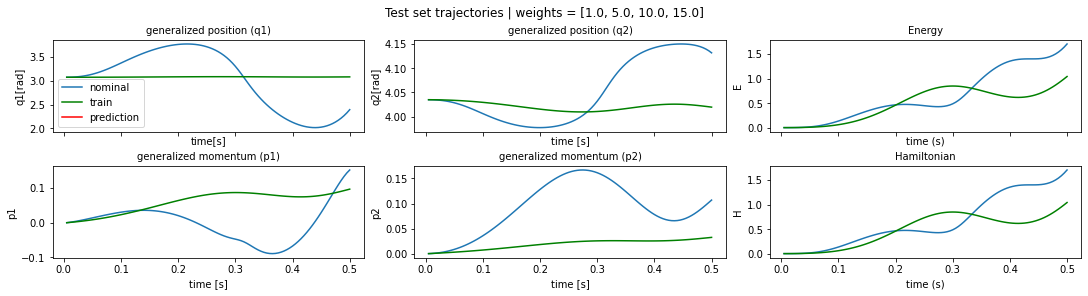

In [111]:
n = 0
plot_furuta_hat_nom(model, u_func, g_func, utype, gtype, data_loader_t=test_loader_3, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_test_set_longer'+str(n)+'.png')